In [1]:
!pip install -U wandb -q
!pip install -U albumentations -q
!pip install -U transformers datasets -q

In [2]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import zipfile
import os
import wandb
import copy
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform
from PIL import Image, ImageOps, ImageEnhance
from torchvision import datasets
from tqdm import tqdm
import cv2

In [3]:
!nvidia-smi

Wed Nov 17 14:44:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# DATA

In [4]:
 from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!unzip -q /content/gdrive/MyDrive/datasets/bird_dataset_cropped_yolov5.zip

replace bird_dataset/test_images/mistery_category/ad08ba64f41b7c50feb7701489a25fc9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [6]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_transforms = A.Compose([
    A.CoarseDropout(p=0.1),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.4),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=.1),
        A.PiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),            
    ], p=0.3),
    A.OneOf([
        A.HueSaturationValue(p=0.1),
        A.ColorJitter(p=0.3),
    ]),
    A.OneOf([
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Flip()
    ], p=0.5),
    A.ElasticTransform(alpha_affine=60, p=0.33),
    A.Rotate(limit=80),
    A.ShiftScaleRotate(p=0.2),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.8),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(250,250),
    A.RandomCrop(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [7]:
class AugmentedDS(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform is not None:
            image = self.transform(image=np.array(image))["image"]
        return image, label
    
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

# MODEL

In [8]:
from transformers import BeitForImageClassification
nclasses = 20
class BEiTNet(torch.nn.Module):
    def __init__(self):
        super(BEiTNet, self).__init__()
        self.beit =  BeitForImageClassification.from_pretrained('microsoft/beit-large-patch16-224')
        self.beit.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.beit.classifier.in_features,512),
            torch.nn.Dropout(p=0.4),
            torch.nn.ReLU(),
            torch.nn.Linear(512,nclasses)
        )

    def forward(self, x):
        return self.beit(x).logits

# Training

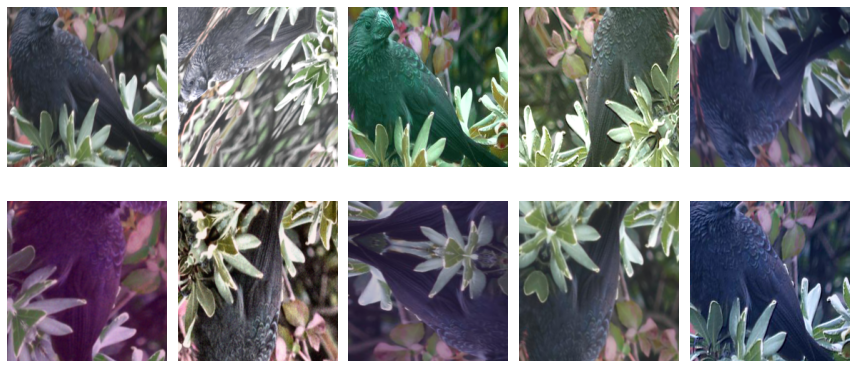

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


BEiTNet(
  (beit): BeitForImageClassification(
    (beit): BeitModel(
      (embeddings): BeitEmbeddings(
        (patch_embeddings): PatchEmbeddings(
          (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): BeitEncoder(
        (layer): ModuleList(
          (0): BeitLayer(
            (attention): BeitAttention(
              (attention): BeitSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=False)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (relative_position_bias): BeitRelativePositionBias()
              )
              (output): BeitSelfOutput(
                (dense): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Drop

In [9]:
torch.cuda.empty_cache()

# Training settings
config = {
    "data": 'bird_dataset',
    "batch_size": 10,
    "epochs": 100,
    "lr": 1e-3,
    "momentum": 0.9,
    "seed": 9823,
    "weight_decay" : 1e-5,
    "experiment": 'experiment',
    "checkpoint": None,
    "clipping": 1.
}

# torch.manual_seed(config["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create experiment folder
if not os.path.isdir(config["experiment"]):
    os.makedirs(config["experiment"])

train_dataset = datasets.ImageFolder(config["data"] + '/train_images',transform=None)
val_dataset = datasets.ImageFolder(config["data"] + '/val_images',transform=data_transforms)

train_dataset = AugmentedDS(train_dataset,transform=train_transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config["batch_size"], 
    shuffle=True, 
    num_workers=1,
    pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False, 
    num_workers=1,
    pin_memory=True)

visualize_augmentations(train_dataset,20)

# Loss function + weighted classes
weights = torch.ones(nclasses)
weights[16] = 0.7
weights[13] = 0.8
weights[16] = 0.7
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device),reduction='mean')

# Neural network and optimizer
model = BEiTNet()
optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
# optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])
scaler = torch.cuda.amp.GradScaler()

if config["checkpoint"] is not None:
    checkpoint = torch.load(config["checkpoint"],map_location=device)
    model.load_state_dict(checkpoint)
    del checkpoint

model.to(device)

In [10]:
def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        with torch.cuda.amp.autocast():
            output = model(data)
            loss = criterion(output, target)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config["clipping"])
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        del data
        del target
    # scheduler.step()
    return epoch_loss/len(train_loader)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in val_loader:
          data = data.to(device)
          target = target.to(device)
          output = model(data)
          # sum up batch loss
          validation_loss += criterion(output, target).item()
          # get the index of the max log-probability
          pred = output.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
          del data
          del target

    validation_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return validation_loss, accuracy

run = wandb.init(
  project="recvis-tp3",
  config=config
)

with tqdm(range(config["epochs"])) as t:
    acc_best = 0
    for epoch in t:
        loss_train = train(epoch) # Train
        loss_val, acc_val = validation() # Test
        scheduler.step()
        # Save current checkpoint
        torch.save(model.state_dict(), f'experiment/model_{int(100.*acc_val)/100.}.pth')
        # If best save best checkpoint
        if (acc_val > acc_best) and (acc_val > 90):
            torch.save(model.state_dict(), f'./gdrive/MyDrive/models/model_{int(100.*acc_val)/100.}.pth')
            acc_best = acc_val

        t.set_postfix(loss_train=loss_train,loss_val=loss_val,acc_val=acc_val)
        wandb.log({
            "loss_train" : loss_train,
            "loss_test" : loss_val,
            "acc_test" : acc_val,
            "lr": scheduler.get_last_lr()[0]
        })

wandb: Currently logged in as: lmagne (use `wandb login --relogin` to force relogin)


  0%|          | 0/100 [00:21<?, ?it/s]


KeyboardInterrupt: ignored